Initial Capital = 100,000

## Part 1

In [1]:
def apply_func_decorator(func):
    prev_row = {}
    def wrapper(curr_row, **kwargs):
        val = func(curr_row, prev_row)
        prev_row.update(curr_row)
        #prev_row[new_col] = val
        return val
    return wrapper

In [2]:
@apply_func_decorator
def DailyRecord1(row,prev_row):
    if row['ma_5d'] > row['ma_20d']:
        row['long/short'] = 1
        row['Transaction_type'] = 'buy'
    elif row['ma_5d']< row['ma_20d']:
        row['long/short'] = -1
        row['Transaction_type'] = 'sell'
    else:
        pass
    try:
        position_pre = prev_row['Position']
        quantity_pre = prev_row['Quantity']
        long_short_pre = prev_row['long/short']
        cash_pre = prev_row['Cash']
    except:
        position_pre = float('NaN')
        quantity_pre = 0
        long_short_pre = 0
        cash_pre = 0
        
    if math.isnan(position_pre):
        position_pre = 100000
        
    if long_short_pre != row['long/short']:
        row['Quantity'] = int(position_pre/row['Price'])
        row['Holding'] = row['long/short']*row['Quantity']*row['Price']
        row['Cash'] = position_pre - row['Holding']
    else:
        row['Quantity'] = quantity_pre
        row['Cash'] = cash_pre
        row['Holding'] = row['long/short']*row['Quantity']*row['Price']
    row['Position'] = row['Cash']+row['Holding']
    if math.isnan(row['Position']):
        row['Quantity'] = 0
    if math.isnan(long_short_pre):
        long_short_pre=0
    row['Transaction_size'] = row['Quantity']*row['long/short']-quantity_pre*long_short_pre
    row['Transaction_value'] = row['Transaction_size']*row['Price']
    
    return row

#### download  daily historical data on AAPL from Jan 1, 2002-Jan 1, 2010.

In [3]:
import matplotlib.pyplot as plt
import datetime
from collections import deque
import pandas as pd
import numpy as np
import math

In [4]:
AAPL = pd.read_csv('AAPL.csv',parse_dates=['Date'],index_col=0)
AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,1.575000,1.664286,1.568571,1.664286,1.122321,132374200
2002-01-03,1.642857,1.696429,1.626429,1.684286,1.135809,153001800
2002-01-04,1.667143,1.710714,1.642143,1.692143,1.141107,102494000
2002-01-07,1.694286,1.714286,1.625000,1.635714,1.103054,111146000
2002-01-08,1.625000,1.646429,1.604286,1.615000,1.089085,112509600


## Moving Average Strategy

C:\Users\eliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  del sys.path[0]
C:\Users\eliza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  


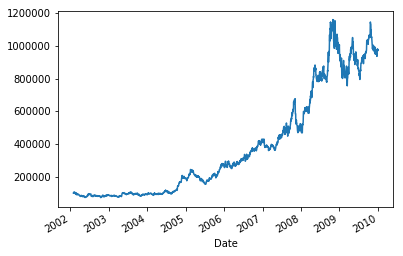

In [5]:
Strategy1=pd.DataFrame(columns = ['Price',
                                  'ma_5d',
                                  'ma_20d',
                                  'long/short',
                                  'Quantity',
                                  'Position',
                                  'Cash','Holding',
                                  'Transaction_type',
                                  'Transaction_size',
                                  'Transaction_value',
                                 ])
Strategy1['Price'] = AAPL['Adj Close']
Strategy1['ma_5d'] = pd.rolling_mean(AAPL['Adj Close'],window=5)
Strategy1['ma_20d'] = pd.rolling_mean(AAPL['Adj Close'],window=20)
#Strategy1[['Price','ma_5d','ma_20d']].plot()
Strat1 = Strategy1.apply(DailyRecord1, axis=1)
Strat1['Position'].plot()
plt.savefig("./"+'Strategy1')

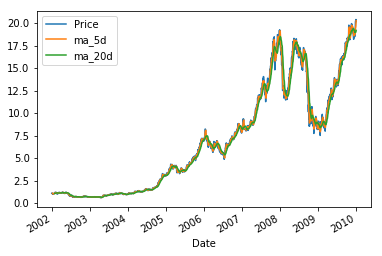

In [6]:
Strat1[['Price','ma_5d','ma_20d']].plot()
plt.savefig("./"+'MovingAverage')

In [7]:
Trade1 = Strat1[Strat1['Transaction_size']!=0][['Transaction_type','Price','Transaction_size','Transaction_value','Position']].dropna(axis=0)
Trade1['Gain/Loss'] =  Trade1['Position']-Trade1.shift(1)['Position']
Trade1.to_csv('Trade1.csv')
Trade1.head()

,Transaction_type,Price,Transaction_size,Transaction_value,Position,Gain/Loss
Date,,,,,,
2002-01-30,buy,1.160374,86179.0,99999.870946,100000.000000,NaN
2002-02-20,sell,1.114133,-170457.0,-189911.768781,93897.923547,-6102.076453
2002-03-07,buy,1.174343,160986.0,189052.782198,90081.984263,-3815.939284
2002-03-26,sell,1.130028,-153056.0,-172957.565568,86276.270259,-3805.714004
2002-04-05,buy,1.191684,144302.0,171962.384568,80980.543935,-5295.726324


In [8]:
Trade1['Position'][-1]/Trade1['Position'][0]-1

8.368130122980004

In [9]:
Trade1[Trade1['Gain/Loss']>0]['Gain/Loss'].count()

45

In [10]:
len(Trade1)

125

In [11]:
hit_ratio= Trade1[Trade1['Gain/Loss']>0]['Gain/Loss'].count()/(len(Trade1)-Trade1[Trade1['Gain/Loss']>0]['Gain/Loss'].count()-1)
print(hit_ratio)

0.569620253164557


## Strategy2

In [12]:
AAPL['daily_return'] = AAPL['Adj Close'].pct_change().iloc[1:]

In [13]:
@apply_func_decorator
def DailyRecord2(row,prev_row):

    try:
        position_pre = prev_row['Position']
        quantity_pre = prev_row['Quantity']
        long_short_pre = prev_row['long/short']
        cash_pre = prev_row['Cash']
        price_pre = prev_row['Price']
    except:
        position_pre = float('NaN')
        quantity_pre = 0
        long_short_pre = 0
        cash_pre = 0
        price_pre = 0
        
    if math.isnan(position_pre):
        position_pre = 100000
        cash_pre = 100000
    
    if math.isnan(row['long']):
        row['long'] = 0
    if math.isnan(row['short']):
        row['short'] = 0
    row['long/short'] = long_short_pre + row['long'] + row['short']
    row['Quantity'] = int(row['long/short']*position_pre/row['Price'])
    row['Transaction_size'] = row['Quantity']-quantity_pre
    row['Transaction_value'] = row['Transaction_size']*row['Price']
    row['Holding'] = row['Quantity']*row['Price']
    row['Cash'] = cash_pre - row['Transaction_value']
    row['Position'] = row['Cash']+row['Holding']



    if row['Transaction_size'] > 0 :
        row['Transaction_type'] = 'buy'
    elif row['Transaction_size'] < 0:
        row['Transaction_type'] = 'sell'
    
    return row

In [14]:
TradingDate = AAPL.index
long = {}
short = {}
for i in range(len(TradingDate)):
    this_trading_day = TradingDate[i]
    if this_trading_day not in long.keys():
        long[this_trading_day] = 0
    if this_trading_day not in short.keys():
        short[this_trading_day] = 0
    try: 
        next_trading_day = TradingDate[i+1]
        third_trading_day = TradingDate[i+2]
        long_date = TradingDate[i+3]
        short_1 = TradingDate[i+4]
        short_5 = TradingDate[i+8]
        short_10 = TradingDate[i+13]
        
        if AAPL.loc[this_trading_day]['daily_return'] < 0 and AAPL.loc[next_trading_day]['daily_return'] < 0 and AAPL.loc[third_trading_day]['daily_return'] < 0:
            long[long_date] =1
            if short_1 not in short.keys():
                short[short_1] = -1/3
            else:
                short[short_1] = short[short_1]-1/3
            if short_5 not in short.keys():
                short[short_5] = -1/3
            else:
                short[short_5] = short[short_5]-1/3
            short[short_10] = -1/3
    except:
        print('last 13 days')


last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days
last 13 days


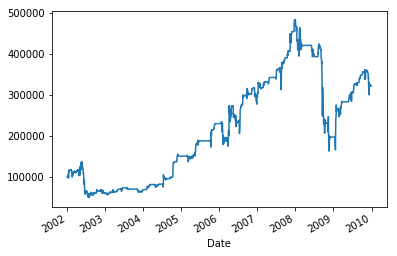

In [15]:
Strategy2=pd.DataFrame(columns = ['Price',
                                  'long',
                                  'short',
                                  'long/short',
                                  'Quantity',
                                  'Position',
                                  'Cash','Holding',
                                  'Transaction_type',
                                  'Transaction_size',
                                  'Transaction_value',
                                 ])
Strategy2['Price'] = AAPL['Adj Close']
Strategy2['long'] = Strategy2.index.map(lambda x:long[x])
Strategy2['short'] = Strategy2.index.map(lambda x:short[x])
Strat2 = Strategy2.apply(DailyRecord2, axis=1)
Strat2['Position'].plot()
plt.savefig("./"+'Strategy2')

In [16]:
Trade2 = Strat2[['Transaction_type','Price','Transaction_size','Transaction_value','Position']].dropna(axis=0)
Trade2['Gain/Loss'] =  Trade2['Position']-Trade2.shift(1)['Position']
Trade2.to_csv('Trade2.csv')
Trade2.head()

,Transaction_type,Price,Transaction_size,Transaction_value,Position,Gain/Loss
Date,,,,,,
2002-01-10,buy,1.022613,97788,99999.280044,100000.000000,NaN
2002-01-11,buy,1.013943,66586,67514.408598,99152.178040,-847.821960
2002-01-14,buy,1.018759,62721,63897.583239,99943.803224,791.625184
2002-01-15,sell,1.045252,-35862,-37484.827224,105960.231059,6016.427835
2002-01-16,buy,1.000937,20489,20508.198193,97485.740664,-8474.490395


In [17]:
cumulative_return2 = Trade2['Position'][-1]/Trade2['Position'][0]-1
gain_trade2 = Trade2[Trade2['Gain/Loss']>0]['Gain/Loss'].count()
trade_number2 = len(Trade2)
hit_ratio2= Trade2[Trade2['Gain/Loss']>0]['Gain/Loss'].count()/(len(Trade2)-Trade2[Trade2['Gain/Loss']>0]['Gain/Loss'].count()-1)
print('The cumulative return of Strategy2 is '+ str(cumulative_return2))
print('There are '+ str(trade_number2)+' trades, and '+str(gain_trade2) +' of them made money')
print('The hit ratio is '+ str(hit_ratio2))

The cumulative return of Strategy2 is 2.2178721846800036
There are 1105 trades, and 537 of them made money
The hit ratio is 0.9470899470899471


In [31]:
Trade2['Position'][-1]

321787.21846800036

### What 3 metrics would you analyse to determine whether the strategy was good or bad (not including the overall PNL of the strategy)?

In [18]:
daily_return1 = Strat1['Position'].pct_change().iloc[1:].dropna()
daily_return2 = Strat2['Position'].pct_change().iloc[1:].dropna()

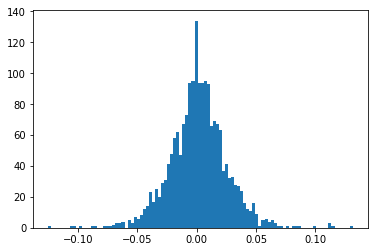

In [19]:
#%matplotlib notebook
plt.hist(daily_return1[daily_return1!=0], bins=100)
plt.show()

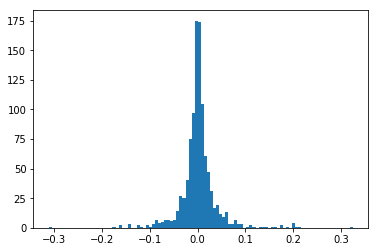

In [20]:
#%matplotlib notebook
plt.hist(daily_return2[daily_return2!=0], bins=100)
plt.show()

#### Volatility

In [21]:
print('The annualized volatility for strategy 1 is '+ str(np.std(daily_return1)*np.sqrt(252)))
print('The annualized volatility for strategy 2 is '+ str(np.std(daily_return2)*np.sqrt(252)))

The annualized volatility for strategy 1 is 0.37643549298729545
The annualized volatility for strategy 2 is 0.45138959416791735


#### Sharpe Ratio
Risk-adjusted return

In [22]:
SharpeRatio1 = np.sqrt(252)*np.mean(daily_return1)/np.std(daily_return1)
SharpeRatio2 = np.sqrt(252)*np.mean(daily_return2)/np.std(daily_return2)

In [23]:
print('The Sharpe Ratio for strategy 1 is '+ str(SharpeRatio1))
print('The Sharpe Ratio for strategy 1 is '+ str(SharpeRatio2))

The Sharpe Ratio for strategy 1 is 0.9531936326753064
The Sharpe Ratio for strategy 1 is 0.5470727236961735


#### Max Drawdown
A drawdown is the 'peak to trough decline' of an investment strategy. 

In [24]:
def max_drawdown(returns, rolling=None):
    r = pd.DataFrame(returns).add(1).cumprod()

    x = r.dot(1 / r.T.copy()) - 1
    x.columns.name, x.index.name = 'start', 'end'

    y = x.stack().reset_index()
    y = y[y.start < y.end]

    
    if not rolling is None:
        y = y[y.end - y.start <= rolling]
    z = y.set_index(['start', 'end']).iloc[:, 0]
    return z.min(), z.idxmin()

In [25]:
max_drawdown1,(start1,end1) = max_drawdown(daily_return1)
max_drawdown2,(start2,end2) = max_drawdown(daily_return2)

In [26]:
print('the max drawdown for strategy 1 over the trading period is ' + str(max_drawdown1)+' from ' +str(start1)+' to '+str(end1))
print('the max drawdown for strategy 2 over the trading period is ' + str(max_drawdown2)+' from ' +str(start2)+' to '+str(end2))

the max drawdown for strategy 1 over the trading period is -0.37133276383885694 from 2005-02-16 00:00:00 to 2005-07-05 00:00:00
the max drawdown for strategy 2 over the trading period is -0.662907663627478 from 2007-12-28 00:00:00 to 2008-11-20 00:00:00


### Allocation

In [27]:
import operator
import cvxopt as opt
from cvxopt import solvers
 
def calculate_frontier(returns):
    '''
    returns optimal portfolio weights and corresponding sigmas for a desired optimal portfolio return
    Params:
    - returns: T x N matrix of observed data
    '''
    returns = pd.DataFrame(returns)
    cov = np.matrix(np.cov(returns.T))
    N = returns.shape[1]
    pbar = np.matrix(returns.mean())
    #print(pbar)
    
    # define list of optimal / desired mus for which we'd like to find the optimal sigmas
    optimal_mus = []
    r_min = pbar.mean()    # minimum expected return
    r_max = np.max(np.max(pbar))
    for i in range(100):
        optimal_mus.append(r_min)
        r_min +=((r_max-r_min) / 100)
#     for i in range(25):
#         optimal_mus.append(r_min)
#         r_min += (pbar.mean() / 100)
#         print(r_min)
    
    # constraint matrices for quadratic programming
    P = opt.matrix(cov)
    q = opt.matrix(np.zeros((N, 1)))
    G = opt.matrix(np.concatenate((-np.array(pbar), -np.identity(N)), 0))
    A = opt.matrix(1.0, (1,N))
    b = opt.matrix(1.0)
    
    # hide optimization
    opt.solvers.options['show_progress'] = False
    
    # calculate portfolio weights, every weight vector is of size Nx1
    # find optimal weights with qp(P, q, G, h, A, b)
    optimal_weights = [solvers.qp(P, q, G, opt.matrix(np.concatenate((-np.ones((1, 1)) * mu, np.zeros((N, 1))), 0)), A, b)['x'] for mu in optimal_mus]
    
    # find optimal sigma
    # \sigma = w^T * Cov * w
    optimal_sigmas = [np.sqrt(np.matrix(w).T * cov.T.dot(np.matrix(w)))[0,0] for w in optimal_weights]
    
    return optimal_weights, optimal_mus, optimal_sigmas

In [28]:
returns = pd.DataFrame()
returns['returns1'] = daily_return1
returns['returns2'] = daily_return2

In [29]:
optimal_weights, optimal_mus, optimal_sigmas = calculate_frontier(returns)
optimal_sharpe = list(map(lambda x,y: x/y, optimal_mus, optimal_sigmas))
index, value = max(enumerate(optimal_sharpe), key=operator.itemgetter(1))
max_sharpe= value*np.sqrt(252)
w1 = optimal_weights[index][0]
w2 = optimal_weights[index][1]

In [30]:
print('We should allocate '+str(w1)+' of the total capital into Strategy 1 and '+str(w2)+' of the capital into Strategy 2 to maximize our Sharpe Ratio, the max sharpe ratio is '+ str(max_sharpe))

We should allocate 0.6188295193312496 of the total capital into Strategy 1 and 0.3811704806687504 of the capital into Strategy 2 to maximize our Sharpe Ratio, the max sharpe ratio is 1.2780693062469208


## Improvement